In [1]:
import awkward as ak
import numpy as np
import pandas as pd
import numba
import glob
from tqdm import tqdm
print(ak.__version__)

run_local = True
debug = True

filepath = "Phase2-L1MenuTools/cache/V37nano/V37nano_VBFHToTauTau*"
debug = True

files = glob.glob(filepath)
print(files)
#Get the files:
arrays = [ak.from_parquet(file) for file in files]
# Get the objectnames:
import re
regex = re.compile(r'^{}|{}$'.format(re.escape(filepath[:-1]+"_"), re.escape(".parquet")))


objectnames = [regex.sub("",file) for file in files]
print(objectnames)

2.6.4
['Phase2-L1MenuTools/cache/V37nano/V37nano_VBFHToTauTau_GenJet.parquet', 'Phase2-L1MenuTools/cache/V37nano/V37nano_VBFHToTauTau_GenJetAK8.parquet', 'Phase2-L1MenuTools/cache/V37nano/V37nano_VBFHToTauTau_GenMET.parquet', 'Phase2-L1MenuTools/cache/V37nano/V37nano_VBFHToTauTau_GenPart.parquet', 'Phase2-L1MenuTools/cache/V37nano/V37nano_VBFHToTauTau_GenVisTau.parquet', 'Phase2-L1MenuTools/cache/V37nano/V37nano_VBFHToTauTau_L1EGbarrel.parquet', 'Phase2-L1MenuTools/cache/V37nano/V37nano_VBFHToTauTau_L1EGendcap.parquet', 'Phase2-L1MenuTools/cache/V37nano/V37nano_VBFHToTauTau_L1TrackHT.parquet', 'Phase2-L1MenuTools/cache/V37nano/V37nano_VBFHToTauTau_L1TrackJet.parquet', 'Phase2-L1MenuTools/cache/V37nano/V37nano_VBFHToTauTau_L1TrackMET.parquet', 'Phase2-L1MenuTools/cache/V37nano/V37nano_VBFHToTauTau_L1caloJet.parquet', 'Phase2-L1MenuTools/cache/V37nano/V37nano_VBFHToTauTau_L1caloTau.parquet', 'Phase2-L1MenuTools/cache/V37nano/V37nano_VBFHToTauTau_L1gmtMuon.parquet', 'Phase2-L1MenuTools/ca

In [2]:
#Store objects in a dict
objectsdict = dict()
for idx,item in enumerate(objectnames): 
    objectsdict[item] = arrays[idx]

Some functions were heavily inspired by:
[L1 TopoTrigger](https://gitlab.cern.ch/uhh-l1t/topotrigger/)
And 
The [L1 ML Tutorial]()

In [3]:
#helper functions:
import vector
vector.register_awkward()


def prepare_objects(dictobj):
    fourvectordict = dict()
    standardizeddict = dict()
    vector.register_awkward()

    for key,value in dictobj.items():
        standardizeddict[key] = value
        fields = value.fields
        for field in fields:
            standardname = field.replace(key+"_","")
            standardizeddict[key][standardname] = dictobj[key][field]
            standardizeddict[key] = ak.without_field(standardizeddict[key],field)
            dictobj[key] = ak.without_field(value,field)
        print(key,":",standardizeddict[key].fields)
        fourvectordict[key] =  ak.Array(standardizeddict[key],with_name="Momentum3D")
    return fourvectordict,standardizeddict



    # # combining to numpy
def prepare_for_ml(objects,padlist,namelist,pad_val = 0):
    pad_arrs = []
    var_names = []
    for idx,object in enumerate(objects):
        topad = padlist[idx]
        name = namelist[idx]
        
        if topad == 1:
            pad_arr = object
        else:
            pad_arr = ak.pad_none(object,topad,axis=1,clip=True)
        for i in range(topad):
            for var in object.fields:
                if topad == 1:
                    pad_arrs += [ak.to_numpy(pad_arr[var][:])]
                else:
                    pad_arrs += [ak.to_numpy( ak.fill_none(pad_arr[var][:,i], pad_val) )]
                var_names.append( "{}_{}_{}".format(name, i, var) )
    return var_names, pad_arrs 




In [4]:
fourvectordict,standardizeddict = prepare_objects(objectsdict)


GenJet : ['pt', 'eta', 'phi', 'partonFlavour']
GenJetAK8 : ['pt', 'eta', 'phi']
GenMET : ['phi', 'pt']
GenPart : ['pt', 'eta', 'phi', 'pdgId', 'statusFlags']
GenVisTau : ['status', 'charge', 'genPartIdxMother', 'eta', 'mass', 'phi', 'pt']
L1EGbarrel : ['eleId', 'phoId', 'saId', 'hwQual', 'eta', 'phi', 'pt']
L1EGendcap : ['eleId', 'phoId', 'saId', 'hwQual', 'eta', 'phi', 'pt']
L1TrackHT : ['ht', 'mht']
L1TrackJet : ['pt', 'eta', 'phi']
L1TrackMET : ['pt']
L1caloJet : ['et', 'eta', 'phi', 'pt']
L1caloTau : ['eta', 'phi', 'pt']
L1gmtMuon : ['charge', 'chargeNoPh', 'hwBeta', 'hwEta', 'hwIso', 'hwPhi', 'hwPt', 'hwQual', 'd0', 'eta', 'phi', 'pt', 'z0']
L1gmtTkMuon : ['charge', 'chargeNoPh', 'hwBeta', 'hwEta', 'hwIso', 'hwPhi', 'hwPt', 'hwQual', 'd0', 'eta', 'phi', 'pt', 'z0']
L1hpsTau : ['eta', 'phi', 'pt']
L1nnCaloTau : ['hwIso', 'hwQual', 'eta', 'phi', 'pt']
L1nnPuppiTau : ['charge', 'id', 'passLooseNN', 'passLooseNNMass', 'passLoosePF', 'passMass', 'passTightNN', 'passTightNNMass', 'passT

In [5]:
#Remove the "et" field from the jets
standardizeddict["L1puppiJetHisto"] = ak.without_field(standardizeddict["L1puppiJetHisto"],'et')
standardizeddict["L1caloJet"] = ak.without_field(standardizeddict["L1caloJet"],'et')



Check if the dicts contain the right data

In [6]:

fourvectordict["L1gmtMuon"].type.show()

99701 * var * Momentum3D[
    charge: int32,
    chargeNoPh: int32,
    hwBeta: int32,
    hwEta: int32,
    hwIso: int32,
    hwPhi: int32,
    hwPt: int32,
    hwQual: int32,
    d0: float32,
    eta: float32,
    phi: float32,
    pt: float32,
    z0: float32
]


In [7]:

def DeltaRcalc(o1,o2):
    #returns the delta in the dimensions of the second object with delta R  first objects, second
    combo = ak.cartesian({"offl": o1,"trgobj": o2}, nested=True ,axis=-1)
    off,trg = ak.unzip(combo)
    deltaR = off.deltaR(trg)
    return deltaR

def mapObjects(o1,o2):
    combo = ak.cartesian({"offl": o1,"trgobj": o2}, nested=True)
    off,trg = ak.unzip(combo)
    return off,trg


def sortbydeltaR(o1,o2):
    o1cart,o2cart = mapObjects(o1,o2)
    dR = DeltaRcalc(o1,o2)
    sorteddR = ak.argsort(dR)    
    return sorteddR

def dRtonumpy(o1,dr):
    o1dR = o1[dr]
    ttpad = ak.pad_none(o1dR,3,clip=True)
    nptt = ak.to_numpy(ttpad)
    npreg = stuctured_to_unstructured(nptt)
    return ak.fill_none(npreg)



### Matching Hadronically Decaying Gen Taus to L1 Calo Taus

This section performs the matching of hadronically decaying generated (Gen) taus to L1 Calorimeter (Calo) taus. The matching is based on the angular distance (ΔR). Specifically, it checks if the Gen tau is within a ΔR of 0.3 from an L1 Calo tau. If such a match is found, the Gen tau is considered "matched" to the L1 Calo tau.

If no hadronically decaying Gen taus are present, the unmatched L1 Calo taus are added to the collection of non-matched taus.


In [8]:
# Calculate DeltaR between GenVisTau and L1caloTau
dr = DeltaRcalc(fourvectordict["GenVisTau"], fourvectordict["L1caloTau"])

# Determine if there are no Gen taus (empty DeltaR values)
drleng = ak.num(dr)
emptydr = drleng == 0

# Create a mask for L1caloTau objects where DeltaR is greater than 0.3
Dr_smaller = ak.any(dr < 0.3, axis=-2, keepdims=True, mask_identity=False)
Dr_greater = ~Dr_smaller  # Inverse mask (where DeltaR is greater than 0.3)

# Apply the mask to select non-matched L1caloTaus
temptaus = ak.mask(fourvectordict["L1caloTau"], Dr_greater)
temp_length = ak.num(temptaus, axis=2)
temp_mask = temp_length == 0

# Flatten the mask to handle cases where there are no Gen taus
Dr_greater_flat = ak.flatten(Dr_greater, axis=-1)
falsepattern = ak.where(emptydr, temp_mask, Dr_greater_flat)

# Separate taus into matched and non-matched categories
nntaus_no_near_taus = falsepattern
nntaus_near_taus = ~nntaus_no_near_taus

# Mask the L1caloTau objects based on the matching criteria
truetaus = ak.drop_none(ak.mask(standardizeddict["L1caloTau"], nntaus_near_taus), axis=1)
falsetaus = ak.drop_none(ak.mask(standardizeddict["L1caloTau"], nntaus_no_near_taus), axis=1)

# Additional 4vectors
v4truetaus = ak.drop_none(ak.mask(fourvectordict["L1caloTau"], nntaus_near_taus), axis=1)
v4falsetaus = ak.drop_none(ak.mask(fourvectordict["L1caloTau"], nntaus_no_near_taus), axis=1)

print(v4falsetaus[15])


[{eta: 1.09, phi: 1.35, pt: 117}, {...}, {eta: -4.1, phi: -1.18, pt: 84}]


In [10]:
# Optional Debug Code

# Print the second element of nntaus_near_taus for inspection
# print(nntaus_near_taus[1])

# Calculate and print DeltaR between the second L1caloTau and GenVisTau
# print(fourvectordict["L1caloTau"][1][1].deltaR(fourvectordict["GenVisTau"][1]))

# Flatten the nntaus_near_taus array and count unique values
x = ak.flatten(nntaus_near_taus, axis=None)
unique, counts = np.unique(x, return_counts=True)
print("True/False values and their counts:", dict(zip(unique, counts)))

# Print the length of the flattened nntaus_near_taus array
# print("Length of flattened nntaus_near_taus:", len(x))

# Show the type of the flattened L1caloTau array
# ak.flatten(fourvectordict["L1caloTau"], axis=-1).type.show()

True/False values and their counts: {False: 251829, True: 88096}


In [11]:
def mapObjects(objects_a, objects_b):
    
    # Create a Cartesian product between  objects
    paired_objects = ak.cartesian({"a": objects_a, "b": objects_b}, nested=True)
    
    # Unzip the pairs into separate arrays 
    mapped_a, mapped_b = ak.unzip(paired_objects)
    
    # Return the mapped  objects
    return mapped_a, mapped_b



def prepare_relative_dR(obj_a, obj_b, vec_a, vec_b, mask):
    """
    Prepares a sorted, flattened array of objects based on their DeltaR values.

    Parameters:
    - obj_a, obj_b: Input objects to be mapped using mapObjects function.
    - vec_a, vec_b: fourvectors used to calculate DeltaR.
    - mask: Boolean mask used for masking objects based on  matching.

    Returns:
    - Flattened array of sorted objects after applying the mask.
    """
    # Map obj_a and obj_b into mapped objects:
    mapped_obj_a, mapped_obj_b = mapObjects(obj_a, obj_b)
    
    # Calculate DeltaR between vec_c and vec_d
    delta_r = DeltaRcalc(vec_a, vec_b)
    
    # Sort the objects based on their DeltaR values
    sorted_indices = ak.argsort(delta_r)
    sorted_objects = mapped_obj_b[sorted_indices]
    
    # Apply  mask and flatten the result
    filtered_objects = ak.flatten(sorted_objects[ak.any(mask, axis=1)], axis=1)
    
    return filtered_objects

In [31]:
#remove empty fields:
for key, value in standardizeddict.items():
    for field in value.fields:
        if ak.sum(value[field]) == 0:
            print(key,field,"field removed")
            standardizeddict[key] = ak.without_field(standardizeddict[key],field)
#remove physical vals:
removal = ["L1gmtMuon",
"L1gmtTkMuon",
]            
for i in removal:
    print("before",standardizeddict[i].fields)
    standardizeddict[i] = ak.without_field(standardizeddict[i],'pt')
    standardizeddict[i] = ak.without_field(standardizeddict[i],'eta')
    standardizeddict[i] = ak.without_field(standardizeddict[i],'phi')
    print("after",standardizeddict[i].fields)

#print all the data
for key, value in standardizeddict.items():
    print(key,":",value.fields)

before ['charge', 'hwBeta', 'hwEta', 'hwPhi', 'hwPt', 'hwQual']


FieldNotFoundError: no field 'pt' in record with 6 fields

This error occurred while calling

    ak.without_field(
        <Array [[], [], [], ..., [{...}], []] type='99701 * var * {charge: ...'>
        'pt'
    )

In [14]:
# Prepare true and false matched muons
true_muons = prepare_relative_dR(truetaus, standardizeddict["L1gmtMuon"], v4truetaus, fourvectordict["L1gmtMuon"], nntaus_near_taus)
false_muons = prepare_relative_dR(falsetaus, standardizeddict["L1gmtMuon"], v4falsetaus, fourvectordict["L1gmtMuon"], ~nntaus_near_taus)

# Prepare true and false matched track muons
true_tkmuons = prepare_relative_dR(truetaus, standardizeddict["L1gmtTkMuon"], v4truetaus, fourvectordict["L1gmtTkMuon"], nntaus_near_taus)
false_tkmuons = prepare_relative_dR(falsetaus, standardizeddict["L1gmtTkMuon"], v4falsetaus, fourvectordict["L1gmtTkMuon"], ~nntaus_near_taus)

# Prepare true and false matched photons
true_photons = prepare_relative_dR(truetaus, standardizeddict["L1tkPhoton"], v4truetaus, fourvectordict["L1tkPhoton"], nntaus_near_taus)
false_photons = prepare_relative_dR(falsetaus, standardizeddict["L1tkPhoton"], v4falsetaus, fourvectordict["L1tkPhoton"], ~nntaus_near_taus)

# Prepare true and false matched electrons
true_electrons = prepare_relative_dR(truetaus, standardizeddict["L1tkElectron"], v4truetaus, fourvectordict["L1tkElectron"], nntaus_near_taus)
false_electrons = prepare_relative_dR(falsetaus, standardizeddict["L1tkElectron"], v4falsetaus, fourvectordict["L1tkElectron"], ~nntaus_near_taus)

# Prepare true and false matched  puppi jets
true_jets = prepare_relative_dR(truetaus, standardizeddict["L1puppiJetHisto"], v4truetaus, fourvectordict["L1puppiJetHisto"], nntaus_near_taus)
false_jets = prepare_relative_dR(falsetaus, standardizeddict["L1puppiJetHisto"], v4falsetaus, fourvectordict["L1puppiJetHisto"], ~nntaus_near_taus)

# Prepare true and false matched calo jets
true_calojets = prepare_relative_dR(truetaus, standardizeddict["L1caloJet"], v4truetaus, fourvectordict["L1caloJet"], nntaus_near_taus)
false_calojets = prepare_relative_dR(falsetaus, standardizeddict["L1caloJet"], v4falsetaus, fourvectordict["L1caloJet"], ~nntaus_near_taus)

# Prepare the objects for ML input
objects_to_map = [true_muons, true_electrons, true_photons, true_jets, true_tkmuons, true_calojets]
fields = (
    true_muons.fields
    + true_electrons.fields
    + true_photons.fields
    + true_jets.fields
    + true_tkmuons.fields
    + true_calojets.fields
)
object_names = [
    "L1gmtMuon",
    "L1tkElectron",
    "L1tkPhoton",
    "L1puppiJetHisto",
    "L1gmtTkMuon",
    "L1caloJet"
]
pad_lengths = [2, 5, 5, 5, 3, 4]

# Prepare data for true object mappings
dr_true_names, temp_true_values = prepare_for_ml(objects_to_map, pad_lengths, object_names)

# Prepare false objects for ML input
false_objects_to_map = [false_muons, false_electrons, false_photons, false_jets, false_tkmuons, false_calojets]

# Print lengths of each false object (for debugging)
for obj in false_objects_to_map:
    print(len(obj))


# Prepare data for false object mappings
dr_false_names, temp_false_values = prepare_for_ml(false_objects_to_map, pad_lengths, object_names)

# Convert and prepare for ML model training
dr_true_values = np.vstack(temp_true_values)
dr_true_values = np.swapaxes(dr_true_values, 0, 1)
dr_true_values = ak.to_numpy(dr_true_values)
dr_false_values = np.vstack(temp_false_values)
dr_false_values = np.swapaxes(dr_false_values, 0, 1)
dr_false_values = ak.to_numpy(dr_false_values)

251829
251829
251829
251829
251829
251829


In [15]:
## uncomment if you want to do sanity checks (takes a while)
# if debug:
#     for item,value in enumerate(standardizeddict["L1caloTau"]):
#         if len(value) != len(v4truetaus[item]) + len(v4falsetaus[item]):
#             print(item)




In [16]:
# Prepare the true objects by broadcasting them to the shape of truetaus
from numpy.lib.recfunctions import structured_to_unstructured

# Flatten truetaus and convert to numpy
flattened_truetaus = ak.flatten(truetaus)
numpy_truetaus = ak.to_numpy(flattened_truetaus)

# Convert truetaus to an unstructured numpy array
unstructured_truetaus = structured_to_unstructured(numpy_truetaus)

# Concatenate the unstructured truetaus with the true deltaR values
trues = np.concatenate((unstructured_truetaus, dr_true_values), axis=1)


In [17]:
truetausnames = ["calotaus_" + i for i in truetaus.fields]

names =  truetausnames  + dr_true_names
print(len(names))
print(names)

153
['calotaus_eta', 'calotaus_phi', 'calotaus_pt', 'L1gmtMuon_0_charge', 'L1gmtMuon_0_hwBeta', 'L1gmtMuon_0_hwEta', 'L1gmtMuon_0_hwPhi', 'L1gmtMuon_0_hwPt', 'L1gmtMuon_0_hwQual', 'L1gmtMuon_1_charge', 'L1gmtMuon_1_hwBeta', 'L1gmtMuon_1_hwEta', 'L1gmtMuon_1_hwPhi', 'L1gmtMuon_1_hwPt', 'L1gmtMuon_1_hwQual', 'L1tkElectron_0_eleId', 'L1tkElectron_0_phoId', 'L1tkElectron_0_saId', 'L1tkElectron_0_hwQual', 'L1tkElectron_0_charge', 'L1tkElectron_0_eta', 'L1tkElectron_0_phi', 'L1tkElectron_0_pt', 'L1tkElectron_0_relIso', 'L1tkElectron_0_z0', 'L1tkElectron_1_eleId', 'L1tkElectron_1_phoId', 'L1tkElectron_1_saId', 'L1tkElectron_1_hwQual', 'L1tkElectron_1_charge', 'L1tkElectron_1_eta', 'L1tkElectron_1_phi', 'L1tkElectron_1_pt', 'L1tkElectron_1_relIso', 'L1tkElectron_1_z0', 'L1tkElectron_2_eleId', 'L1tkElectron_2_phoId', 'L1tkElectron_2_saId', 'L1tkElectron_2_hwQual', 'L1tkElectron_2_charge', 'L1tkElectron_2_eta', 'L1tkElectron_2_phi', 'L1tkElectron_2_pt', 'L1tkElectron_2_relIso', 'L1tkElectron_2_z

In [18]:
# Prepare the false objects (falsetaus and falsejets)

flattened_falsetaus = ak.flatten(falsetaus)
numpy_falsetaus = ak.to_numpy(flattened_falsetaus)
unstructured_falsetaus = structured_to_unstructured(numpy_falsetaus)
falses = np.concatenate((unstructured_falsetaus, dr_false_values), axis=1)




In [19]:
## some debug stuff to check if the variables are named correctly
# indexlist = drfnames
# print(falses[0][0])
# print(standardizeddict["L1caloJet"].eta[0][0])
# print(falses[0][1])
# print(standardizeddict["L1caloJet"].phi[0][0])


# print(trues[0][0])
# print(standardizeddict["L1caloJet"].eta[1][1])
# print(falses[0][1])
# print(standardizeddict["L1caloJet"].phi[1])
# idx = indexlist.index("L1gmtMuon_0_hwPt")

# print(standardizeddict["L1gmtTkMuon"].hwPt[0])
# tt = falses[0]

# print(np.sum(trues[:,0]))
# for i in range(len(trues[0])):
#     if np.max(trues[:,i]) == np.min(trues[:,i]):
#         print(names[i])
# # tt.where(529)
# indexlist = drfnames
# print(falses[0][0])
# print(standardizeddict["L1caloJet"].eta[0][0])
# print(falses[0][1])
# print(standardizeddict["L1caloJet"].phi[0][0])

# print(drfnames)
# print(trues[0][0])
# print(standardizeddict["L1caloJet"].eta[1][1])
# print(falses[0][1])
# print(standardizeddict["L1caloJet"].phi[1])
# idx = indexlist.index("L1gmtTkMuon_0_hwPt")

# print(standardizeddict["L1gmtTkMuon"].hwPt[0])

# tt = falses[0]
# print(ls)
# # print(drfvals[0])
# print(idx)
# idx = indexlist.index("L1gmtTkMuon_1_hwPt")
# print(idx)
# print(len(drfvals[0]))
# print(np.where(drfvals[0] == 529))
# print(np.where(drfvals[0] == 324))
# print(np.where(drfvals[0] == 102))

In [20]:
x_sig = trues
x_bkg = falses
#some info about the data:
#number of true taus:
print(len(trues))
#number of false taus
print(len(falses))
#number of input variables these two have to match:
print(len(names))
print(trues[0].shape)

88096
251829
153
(153,)


In [21]:

# creating labels
y_bkg = np.zeros(len(x_bkg))
y_sig = np.ones(len(x_sig))

# combining signal & bkg
x = np.concatenate((x_bkg, x_sig))
y = np.concatenate((y_bkg, y_sig))

In [22]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
_ = scaler.fit(x)
x_scaled = scaler.transform(x)

In [23]:
 # make directory
import os
import pickle
from datetime import datetime

datenow = datetime.now().strftime("%Y_%m_%d-%I_%M_%S_%p")
outdir = "smallnet_outputs_for_training_{}/".format(datenow)
if not os.path.exists(outdir):
    os.makedirs(outdir)

with open(outdir+"scaler.pkl", 'wb') as file_pi: 
   pickle.dump(scaler, file_pi)

print("outdir:  ",outdir)

outdir:   smallnet_outputs_for_training_2024_09_07-03_06_22_PM/


In [24]:

with open(outdir+"featurenames.pkl", 'wb') as file_pi: 
   pickle.dump(names, file_pi)

In [25]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.4)
print(X_train.shape[1])
from sklearn.utils.class_weight import compute_class_weight

#weighing trues and false
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)

# Convert class_weights to a dictionary
class_weight_dict = dict(enumerate(class_weights))
print(class_weight_dict)


153
{0: 0.6748158735830703, 1: 1.9300760844878493}


In [26]:
ak.to_parquet(X_train, outdir+"X_train_scaled.parquet")
ak.to_parquet(y_train, outdir+"y_train_scaled.parquet")
ak.to_parquet(X_test, outdir+"X_test_scaled.parquet")
ak.to_parquet(y_test, outdir+"y_test_scaled.parquet")


  created_by: parquet-cpp-arrow version 16.0.0
  num_columns: 1
  num_rows: 135970
  num_row_groups: 1
  format_version: 2.6
  serialized_size: 0

In [27]:
truetaus.fields
truetaus_plot =ak.flatten(truetaus,axis=-1)
truetaus_plot.type.show()

falsetaus_plot =ak.flatten(falsetaus,axis=-1)


88096 * {
    eta: float32,
    phi: float32,
    pt: float32
}


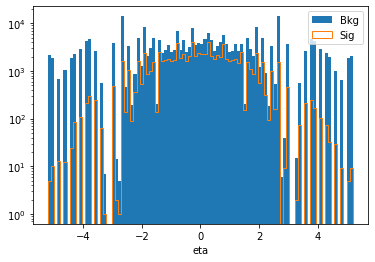

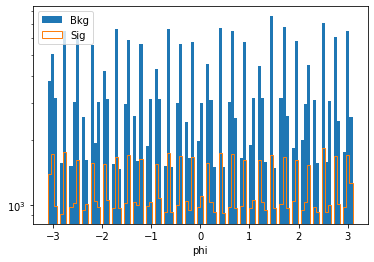

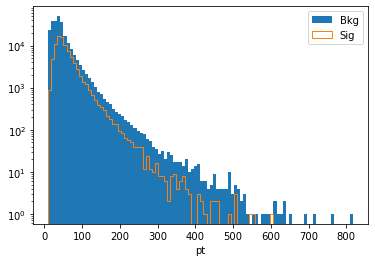

In [28]:
import matplotlib.pyplot as plt


for i in truetaus.fields:
    # if "_0_" not in name: continue
        
    plt.figure()
    
    _ = plt.hist(falsetaus_plot[i], bins = 100, log = True, density = False, label = "Bkg")
    _ = plt.hist(truetaus_plot[i], bins = _[1], histtype = "step", density = False, label = "Sig")
    
    plt.xlabel(i)
    plt.legend()
    plt.show()

['charge', 'hwBeta', 'hwEta', 'hwPhi', 'hwPt', 'hwQual']
[2.52, 3.96, 1.36, 2.97, 2.86, 1.33, ..., 2.03, 2.98, 3.5, 1.58, 1.99, 3.08]


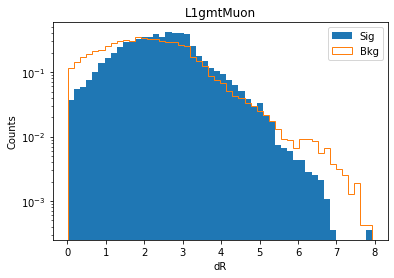

['charge', 'hwBeta', 'hwEta', 'hwPhi', 'hwPt', 'hwQual', 'z0']
[2.36, 2.06, 2.61, 2.46, 1.51, 1.41, ..., 2.56, 3.03, 1.25, 1.25, 1.25, 3.09]


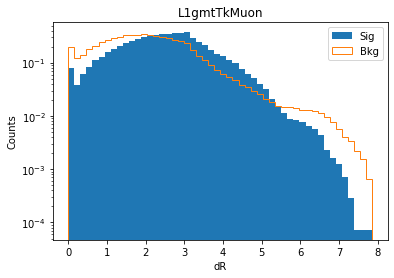

['eleId', 'phoId', 'saId', 'hwQual', 'eta', 'phi', 'pt', 'relIso']
[0.0395, 2.58, 0.0251, 1.61, 2.92, 0.0867, ..., 0.0385, 2.7, 0.0395, 3.3, 1.21]


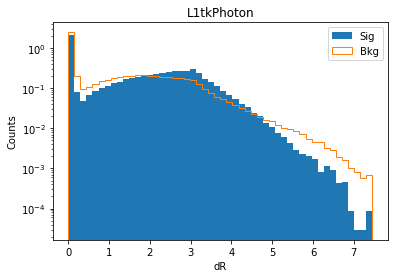

['eleId', 'phoId', 'saId', 'hwQual', 'charge', 'eta', 'phi', 'pt', 'relIso', 'z0']
[0.0395, 2.61, 0.0619, 1.86, 0.443, ..., 4.56, 0.053, 1.76, 0.0619, 0.0586]


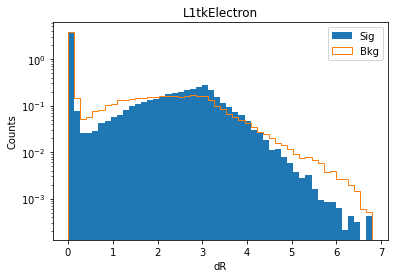

['eta', 'phi', 'pt']
[2.62, 0.0178, 0.0885, 2.5, 1.9, 0.0217, ..., 3.01, 4.62, 0.00215, 4.79, 2.48]


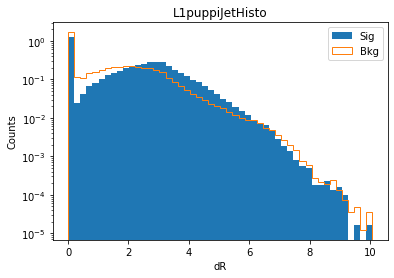

['eleId', 'phoId', 'saId', 'hwQual', 'eta', 'phi', 'pt']
[2.58, 1.61, 0.0248, 0.0391, 0.0872, ..., 3.31, 1.74, 0.039, 2.71, 0.039]


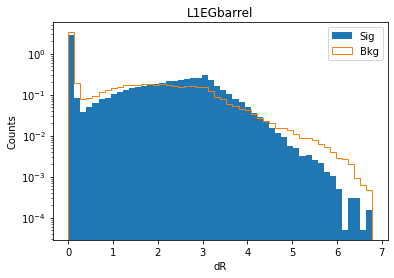

['eleId', 'saId', 'hwQual', 'eta', 'phi', 'pt']
[3.48, 1.45, 1.86, 1.6, 0.407, 2.69, ..., 3.74, 0.143, 0.032, 3.64, 5, 1.52]


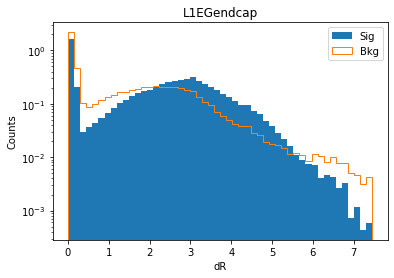

In [30]:
#some quick plots on the dr of the closest l1obj:
def Preparemindrplot(a,b,c,d,sort):
    f,g = mapObjects(a,b)
    dr = DeltaRcalc(c,d)
    drmin = ak.min(dr,axis=1)
    return ak.flatten(drmin,axis=None)
    # muonssorted = g[tts]
    # test = ak.any(nntaus_near_taus,axis=1)
    # mm = ak.flatten(muonssorted[ak.any(sort,axis=1)],axis=1)

y = [
 "L1gmtMuon",
"L1gmtTkMuon",
"L1tkPhoton",
"L1tkElectron",
"L1puppiJetHisto"
]
for x in y:
    print(standardizeddict[x].fields)
    truemuons_plot =  Preparemindrplot(truetaus,standardizeddict[x],v4truetaus,fourvectordict[x],nntaus_near_taus)
    falsemuons_plot = Preparemindrplot(falsetaus,standardizeddict[x],v4falsetaus,fourvectordict[x],~nntaus_near_taus)
    # standardizeddict["L1gmtTkMuon"]
    print(ak.flatten(truemuons_plot,axis=None))

    plt.figure()
        
    _ = plt.hist(ak.flatten(truemuons_plot,axis=None), bins = 50, log = False, density = True, label = "Sig")
    _ = plt.hist(ak.flatten(falsemuons_plot,axis=None), bins = _[1], histtype = "step", density = True, label = "Bkg")
        
    plt.xlabel("dR")
    plt.ylabel("Counts")
    plt.yscale("log")
    plt.title(x)
    plt.legend()
    plt.show()